In [2]:
from imgaug import augmenters as iaa
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator, load_img, img_to_array, array_to_img
import imgaug as ia
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
import time
import os
import cv2
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

/data/wanlijia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


创建用于存放数据增强后图片的目录

In [5]:
def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

root_path = "../../../data/distracted_driver_detection/unzip_data/"
train_dir = root_path + "imgs/train"
train_aug_dir = root_path + "imgs/train_aug"


加载需要做数据增强的数据表

In [6]:
drivers_pd = pd.read_csv(root_path + "driver_imgs_list.csv")

经过抽察数据集发现，ID为p081的这名司机在c0安全驾驶类别中存在多张图像能判断为与其他乘客聊天的状态，属于异常数据，决定弃用p081在c0类别中的所有数据

如：img_6002.jpg、img_28578.jpg、img_45571.jpg、img_47447.jpg、img_49150.jpg、img_51985.jpg、img_5963.jpg、img_3349.jpg

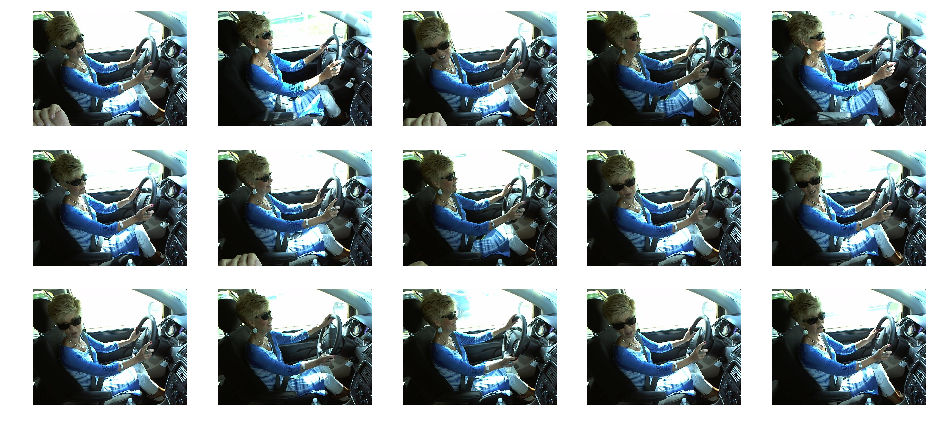

In [7]:
p081_pd = drivers_pd.query("subject=='p081'&classname=='c0'")["img"]
imgs = np.random.choice(p081_pd, 15)

plt.figure(figsize=(16,38))
for i, img in enumerate(imgs):
    plt.subplot(15, 5, i+1)
    img = load_img(train_dir + '/c0/' + img)
    plt.axis('off')
    plt.imshow(img)

踢掉异常值较多的司机的数据

In [8]:
drop_index = drivers_pd.query("subject=='p081'&classname=='c0'")["img"].index
drivers_pd = drivers_pd.drop(drop_index)
drivers_pd.to_csv(root_path + "drivers_img_nop081_list.csv")

踢掉异常值后各类别分布仍然基本属于平均分布

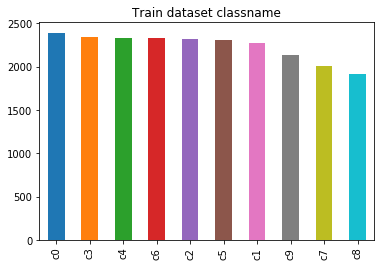

In [9]:
drivers_pd["classname"].value_counts().plot(kind="bar", title="Train dataset classname")

查看数据增强处理前的原始图片，这里选取数据表中同一个司机ID的前10张图片，发现几乎完全一样，连肉眼都不能清楚分辨，图片的重复程度非常高

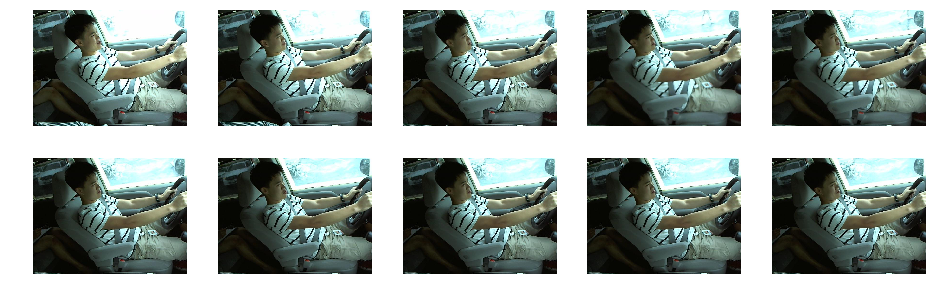

In [12]:
plt.figure(figsize=(16, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    
    driver_id = drivers_pd.at[i, 'subject']
    driver_class = drivers_pd.at[i, 'classname']
    driver_img = drivers_pd.at[i, 'img']
    
    img = load_img(train_dir + '/' + driver_class + '/' + driver_img)
    plt.axis('off')
    plt.imshow(img)

../../../../data/distracted_driver_detection/unzip_data/imgs/train/c0/img_44733.jpg
../../../../data/distracted_driver_detection/unzip_data/imgs/train/c0/img_31798.jpg
write to file: ../../../../data/distracted_driver_detection/unzip_data/imgs/train_aug/img_44733_269.jpg


False

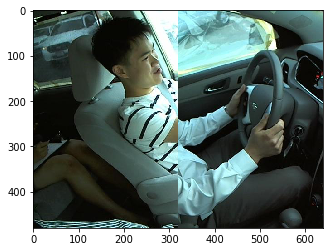

In [11]:
driver_id = drivers_pd.at[0, 'subject']
driver_class = drivers_pd.at[0, 'classname']
driver_img = drivers_pd.at[0, 'img']
path1 = train_dir + '/' + driver_class + '/' + driver_img
print(path1)
img1 = load_img(path1)
img1 = img_to_array(img1)

add_img_name = np.random.choice(drivers_pd.query("classname=='"+driver_class+"' & subject!='"+driver_id+"'")["img"])
path2 = train_dir + '/' + driver_class + '/' + add_img_name
print(path2)
img2 = load_img(path2)
img2 = img_to_array(img2)

left = img1[:, :640//2, :]
right = img2[:, 640//2:, :]
x = np.concatenate((left, right), axis=1)
img = array_to_img(x)
plt.imshow(img)

filename, ext = os.path.splitext(path1)
new_file_name = filename.split("/")[-1] + "_" + str(np.random.randint(0,1000)) + ext
new_path = os.path.join(train_aug_dir, new_file_name)
print("write to file:", new_path)
cv2.imwrite(new_path, x)

生成增强后的图像数据，仅运行一次

In [13]:
# rmrf_mkdir(train_aug_dir)

def cv2_load_img(path):
    img = cv2.imread(path)
    img = np.array(img, dtype=np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def merge_img(img1, img2):
    left = img1[:, :320, :]
    right = img2[:, 320:, :]
    img_arr = np.concatenate((left, right), axis=1)
    return img_arr

def save_merge_img(save_dir, filename, img_arr):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    new_path = os.path.join(save_dir, filename)
#     print("write to file:", new_path)
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_RGB2BGR)
    cv2.imwrite(new_path, img_arr)
    
train_aug_pd = DataFrame({
    "subject":[],
    "classname":[],
    "img":[]
})
aug_img_number = 1
index_list = drivers_pd.index.tolist()
for index in tqdm(index_list):
    id = drivers_pd.at[index, 'subject']
    cls = drivers_pd.at[index, 'classname']
    img_name = drivers_pd.at[index, 'img']
    path1 = train_dir + '/' + cls + '/' + img_name
#     print(path1)
    img1 = cv2_load_img(path1)
    
    for i in range(aug_img_number):
        add_img_name = np.random.choice(drivers_pd.query("classname=='"+cls+"' & subject!='"+id+"'")["img"])
        path2 = train_dir + '/' + cls + '/' + add_img_name
#         print(path2)
        img2 = cv2_load_img(path2)

        new_img = merge_img(img1, img2)

        filename, ext = os.path.splitext(path1)
        new_file_name = filename.split("/")[-1] + "_" + str(i) + ext
        new_file_dir = os.path.join(train_aug_dir, cls)
        save_merge_img(new_file_dir, new_file_name, new_img)
        
        data = {
            "subject": id,
            "classname": cls,
            "img": new_file_name
        }
        train_aug_pd = train_aug_pd.append(data, ignore_index=True)
    train_aug_pd.to_csv(root_path + "drivers_img_aug_checkpoint.csv", index=None)
    
# dirvers_pd.append(train_aug_pd, ignore_index=True)
# drivers_pd.to_csv('data/drivers_img_aug_list.csv', index=None)
train_aug_pd.to_csv(root_path + 'drivers_img_aug_list.csv', index=None)

100%|██████████| 22324/22324 [13:02<00:00, 28.54it/s]
